<a href="https://colab.research.google.com/github/SimonDequidt/Courses/blob/main/Experiments_with_simulated_high_dimensional_regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [ ]:
def scatter_plot(x_: np.ndarray,
                 y_: np.ndarray,
                 name_x: str,
                 name_y: str):
    """
    scatter plot
    """
    data = pd.DataFrame(np.concatenate([x_, y_], axis=1),
                    columns=[name_x, name_y])
    sns.jointplot(data=data, x=name_x, y=name_y, kind="reg")

In [ ]:
def simulate_data(seed: int,
                  sample_size: int,
                  number_features: int,
                  noise_size: float,
                  bstar: float,
                  binomial: bool=False,
                  fraction_nonzero_betas: int=0.1)->tuple:
    """
    now we simulate data

    """
    np.random.seed(seed)
    T = sample_size # sample size
    P = number_features  # number of features (signals or predictors)
    sigma = noise_size # size of noise
    noise = np.random.randn(T, 1) * sigma # noise
    signals = np.random.randn(T, P)
    if not binomial:
      betas = np.sqrt(bstar) * np.random.randn(P, 1) / np.sqrt(P)
    else:
      fraction = int(fraction_nonzero_betas * P)
      betas = np.sqrt(bstar / fraction) * np.random.permutation(np.concatenate([np.ones([fraction, 1]), np.zeros([P - fraction, 1])], axis=0))
    infeasible_predictions = signals @ betas
    labels = infeasible_predictions + noise

    return (labels, infeasible_predictions, signals, betas)

#We now simulate *labels* $y=S\beta+\sigma \epsilon$ with $\beta=(\beta_i)_{i=1}^P$ that are i.i.d., so that all signals are equally predictive ex-ante, and $\sigma$ is the size of noise. We consider two simulations, one where $\beta_i\sim N(0,b_*/P),$ so that the bulk of $\beta_i$ are non-zero and $E[\|\beta\|^2]=E[\sum_i \beta_i^2]=\sum_i E[\beta_i^2]=\sum_i (b_*/P)=P(b_*/P)=b_*.$ Alternatively, when $binomial=True$, we similate data so that exactly $10\%$ of $\beta_i$ are non-zero, so that signals are *sparse*. We call $S\beta$ the *infeasible predictions.* They are infeasible because $\beta$ is not observable.

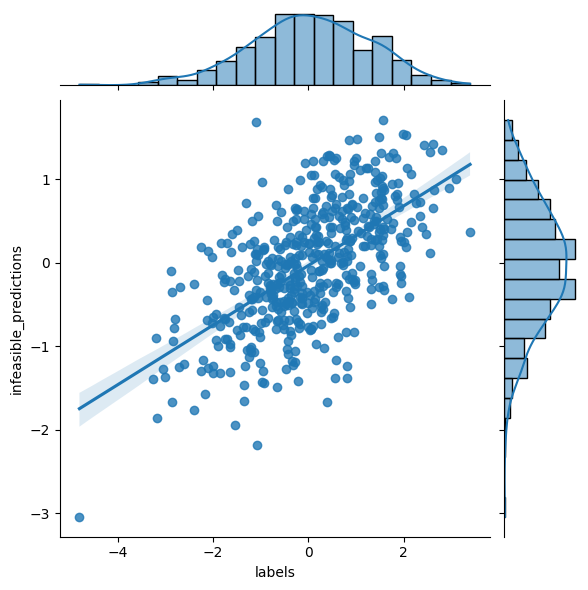

In [ ]:
sample_size = 500
number_features = 1000
noise_size = 1.
seed = 1
(labels, infeasible_predictions, signals, betas) = simulate_data(seed,
                                                                 sample_size,
                                                                 number_features,
                                                                 noise_size,
                                                                 bstar=0.5,
                                                                 binomial=False
                                                                 )

scatter_plot(labels,
             infeasible_predictions,
             'labels',
             'infeasible_predictions')

In [ ]:
def performance_metrics_of_regression(labels: np.ndarray,
                                      predictions: np.ndarray,
                                      printt: bool = True) -> tuple:
    """
    Compute standard performance metrics for regression: mse and Rsquared
    Computation is done using numpy broadcasting
    """
    mse = ((predictions - labels.reshape(-1, 1)) ** 2).mean(0)
    r2 = 1 - mse / (labels ** 2).mean()
    if printt:
      print(f'r2 = {np.round(r2, 2)}')

    return mse, r2

In [ ]:
mse, infeasible_r2 = performance_metrics_of_regression(labels, infeasible_predictions)

r2 = [0.37]


#We now run the ridge regression $\hat\beta(z)=(zI+S'S/T)^{-1}S'R/T$

In [ ]:
def naive_ridge_regression(labels, features, penalty):
    """
    Simple, naive ridge regression
    """
    means = features.T @ labels / features.shape[0]

    # build the sample covariance matrix of signals
    feature_covariance = features.T @ features / features.shape[0] + penalty * np.eye(features.shape[1])
    inverse_covariance = np.linalg.inv(feature_covariance)
    beta_estimate = inverse_covariance @ means
    return beta_estimate

RIDGE=1e-06
RIDGE=100


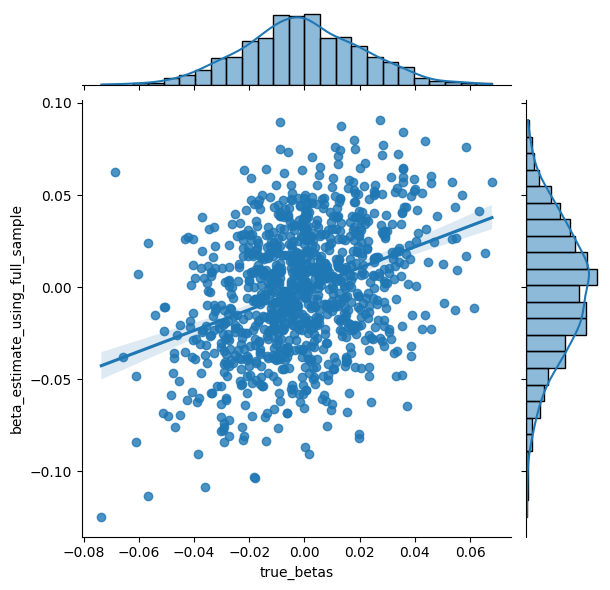

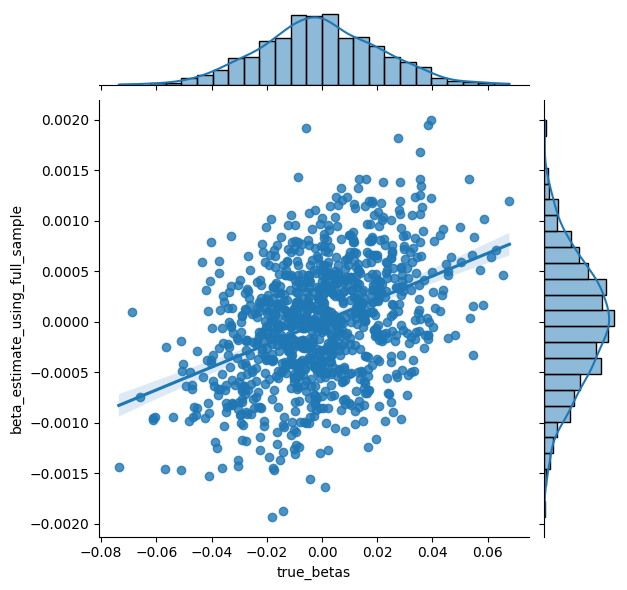

In [ ]:
# when number_features is large relative to the sample size, you do not get the true betas!
ridge = 0.000001
beta_estimate_using_full_sample = naive_ridge_regression(labels,
                                                         features=signals,
                                                         penalty=ridge)
print(f'RIDGE={ridge}')
scatter_plot(betas,
             beta_estimate_using_full_sample,
             'true_betas',
             'beta_estimate_using_full_sample')

ridge = 100
beta_estimate_using_full_sample = naive_ridge_regression(labels,
                                                         features=signals,
                                                         penalty=ridge)
print(f'RIDGE={ridge}')

scatter_plot(betas,
             beta_estimate_using_full_sample,
             'true_betas',
             'beta_estimate_using_full_sample')

# We now use smart mathematics to run ridge regression quickly, for a large set of shrinkage penalties. We use the identity $(zI+S'S)^{-1}S'=S'(zI+SS')^{-1}.$

$$
SS'/T=UDU',\ UU'=I=U'U,
$$
#while $D$ is a diagonal matrix. Then,
$$
(zI+SS'/T)^{-1}\ =\ U(zI+D)^{-1}U'
$$
#I need to compute
$$
\beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
$$

In [ ]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        tmp = eigenvectors.T @ signals
        betas = tmp.T @ intermed
    predictions = future_signals @ betas
    return betas, predictions

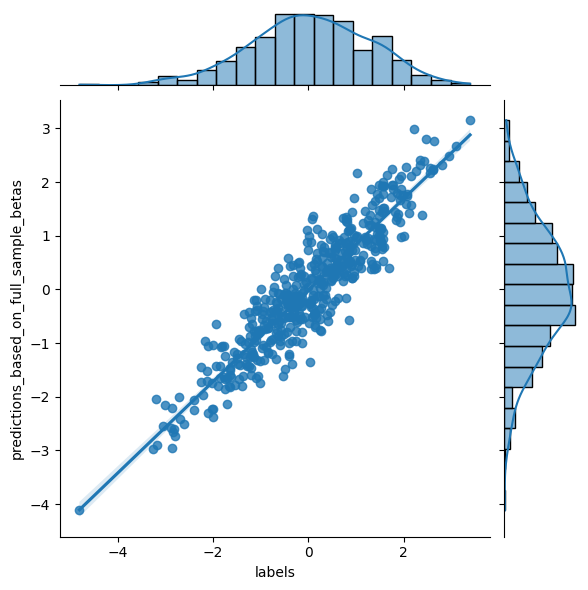

In [ ]:
num_signals_used = 400
beta_estimate_using_full_sample = naive_ridge_regression(labels,
                                                         features=signals[:,:num_signals_used],
                                                         penalty=0.0000001)
predictions_based_on_full_sample_betas = signals[:, :num_signals_used] @ beta_estimate_using_full_sample
scatter_plot(labels,
             predictions_based_on_full_sample_betas,
             'labels',
             'predictions_based_on_full_sample_betas')

In [ ]:
betas_, predictions_ = ridge_regr(signals, # in sample features
                                  labels, # in sample labels
                                  future_signals=signals, # ouf of sample (i.e., test sample) features
                                  shrinkage_list=[0.0001, 0.01, 0.1, 1, 10., 100.])

# With more predictors than data, we are in the over-parametrized regime. With insufficient shrinkage, this will lead to an **IN SAMPLE** $R^2$ that is too high, unless we shrink using a large $z$

In [ ]:
_, overfit_r2 = performance_metrics_of_regression(labels, predictions_)

r2 = [1.   1.   0.99 0.84 0.33 0.05]


# Now, we are going to train the model using train data, and then use test data to compute the out-of-sample $R^2 = 1 - MSE/\|R\|^2$

In [ ]:
# NOW WE START DOING THE TRUE STUFF: TRAIN AND TEST SAMPLE SPLIT
split = int(sample_size / 2)
ridge_penalty = 0.1

train_labels = labels[:split]
test_labels = labels[split:]

beta_estimate_using_train_sample = naive_ridge_regression(train_labels,
                                                          features=signals[:split, :],
                                                          penalty=ridge_penalty)
predictions_based_on_train_sample_betas = signals @ beta_estimate_using_train_sample
performance_metrics_of_regression(test_labels,
                                  predictions_based_on_train_sample_betas[split:])

r2 = [-0.02]


(array([1.69974948]), array([-0.02374474]))

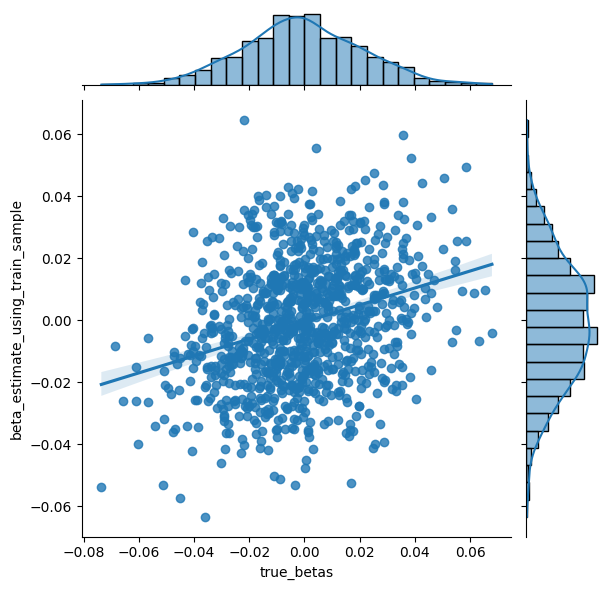

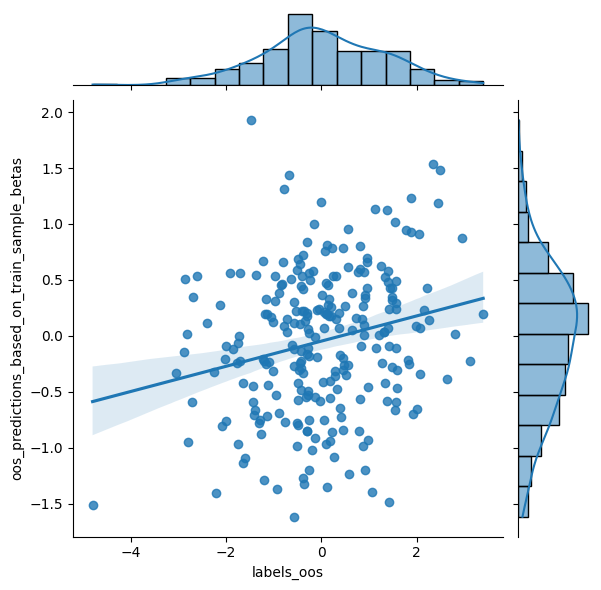

In [ ]:
scatter_plot(betas,
             beta_estimate_using_train_sample,
             'true_betas',
             'beta_estimate_using_train_sample')


scatter_plot(labels[split:],
             predictions_based_on_train_sample_betas[split:],
             'labels_oos',
             'oos_predictions_based_on_train_sample_betas')

# The data was simulated with $b_*=0.5$, and for large $P$ we expect by the law of large numbers that $E[\|\beta\|^2]=b_*.$ In this simulation environment, a mathematical result implies that the best OOS performance is achieved with a ridge penalty $z_*=c/b_*$ where $c=P/T$

In [ ]:
b_star = (betas ** 2).sum()
print(f'b_star={b_star}')
c_ = number_features / split # complexity = P / T
z_optimal = c_ / b_star
print(f'z_optimal={z_optimal}')

b_star=0.4794392306036955
z_optimal=8.34308030021515


In [ ]:
beta_estimate_using_train_sample, predictions \
= ridge_regr(
            signals=signals[:split, :], # train sample signals
            labels=train_labels, # train sample labels
            future_signals=signals[split:], # out of sample signals
            shrinkage_list=[0.01, 0.1, 1, z_optimal, 5, 10, 15, 20, 25, 50, 10, 100, 150, 1000])



r2 = [-0.04 -0.02  0.04  0.05  0.06  0.05  0.04  0.03  0.03  0.02  0.05  0.01
  0.01  0.  ]


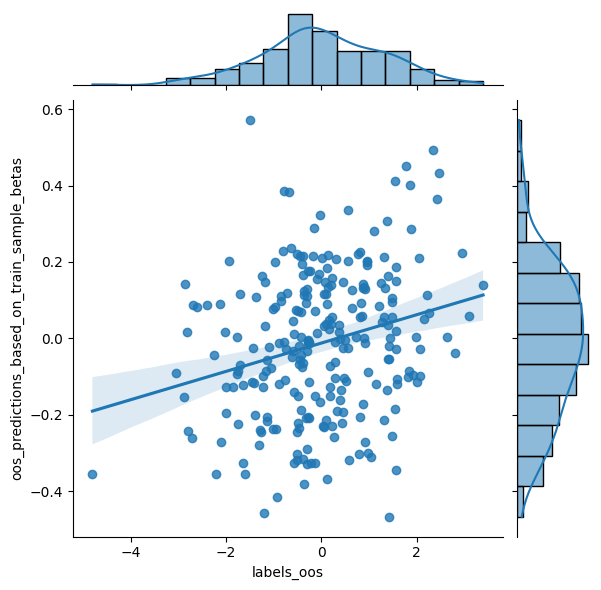

In [ ]:
col = 3 # this is the optimal z

performance_metrics_of_regression(test_labels,
                                  predictions)

scatter_plot(labels[split:],
             predictions[:, col].reshape(-1, 1),
             'labels_oos',
             'oos_predictions_based_on_train_sample_betas')

# If we have predictions $\pi_t,$ we can build s strategy $\pi_t R_{t+1}$. Your wealth evolution is then $W_{t+1}=W_t(R_f+\pi_t R_{t+1}).$ To study the evolution of your bank account, we can show the cumulative performance plot. The product $\pi_t R_{t+1}$ is called **MANAGED RETURNS**

# When we do this, we need to decide how to measure the quality of a prediction $\pi_t.$ First, we think about MSE
$MSE=E[(R_{t+1}-\pi_t)^2]=E[R_{t+1}^2]-2E[\pi_t R_{t+1}]+E[\pi_t^2]$ and $R^2=1-MSE/E[R_{t+1}^2].$

#A positive OOS $R^2$ means that $MSE<E[R_{t+1}^2].$ This,
$$
E[R_{t+1}^2]-2E[\pi_t R_{t+1}]+E[\pi_t^2]\ <\ E[R_{t+1}^2]\,.
$$
#This is equivalent to
$$
-2E[\pi_t R_{t+1}]+E[\pi_t^2]\ <\ 0,
$$
#which is, in turn, equivalent to
$$
E[\pi_t^2]\ <\ 2E[\pi_t R_{t+1}]\,.
$$
#In particular,
$$
E[\pi_t R_{t+1}]\ >\ 0\,.
$$

In [ ]:
R_t = labels[split:]
pi_t = predictions
managed_returns = pi_t * R_t.reshape(-1, 1)
leverage = (pi_t ** 2).mean(0)
perf = 2 * managed_returns.mean(0)

In [ ]:
compare = np.concatenate([leverage.reshape(1, -1), perf.reshape(1, -1)], axis=0)
print(compare)

[[4.44000736e-01 4.12577233e-01 2.36846755e-01 3.64625834e-02
  6.72280079e-02 2.86523002e-02 1.59923650e-02 1.02260540e-02
  7.10789730e-03 2.12832213e-03 2.86523002e-02 5.87652631e-04
  2.70399209e-04 6.46650263e-06]
 [3.83879272e-01 3.73153237e-01 2.96561475e-01 1.22971303e-01
  1.65578620e-01 1.09243669e-01 8.19092215e-02 6.56123500e-02
  5.47569787e-02 3.00197278e-02 1.09243669e-01 1.57876858e-02
  1.07121462e-02 1.65727564e-03]]


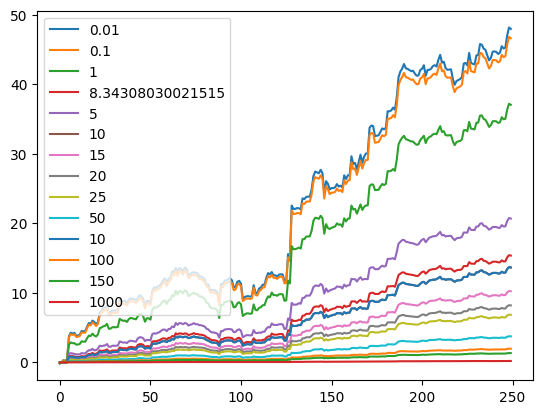

In [ ]:
plt.plot(np.cumsum(managed_returns, axis=0))
shrinkage_list = [0.01, 0.1, 1, z_optimal, 5, 10, 15, 20, 25, 50, 10, 100, 150, 1000]
plt.legend(shrinkage_list)

# We see that MSE and R2 are not good measures of a strategy performance. A better one is Sharpe Ratio (SR) defined as
$SR(X) = E[X]/STD[X]$ where $STD[X]=\sqrt{Var[X]}$

In [ ]:
managed_returns.mean(0) / managed_returns.std(0)

array([0.20211366, 0.20365346, 0.21398847, 0.23333443, 0.2292371 ,
       0.23454641, 0.23679722, 0.23803543, 0.23881733, 0.24047263,
       0.23454641, 0.24134686, 0.24164515, 0.24215998])

#It is a good practice to rescale returns by their realized standard deviation. This way, the CUMULATIVE PERFORMANCE PLOT is ordered by the Sharpe ratio.

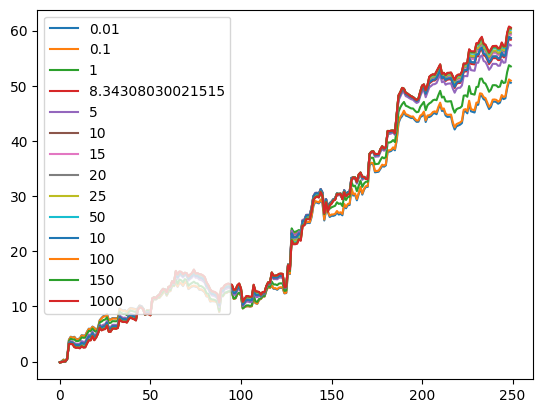

In [ ]:
normalized_managed_returns = managed_returns / managed_returns.std(0).reshape(1, -1)
plt.plot(np.cumsum(normalized_managed_returns, axis=0))
plt.legend(shrinkage_list)

# [The Virtue of Complexity](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984925): If the data is complex, then, as you increase the dimension, performance improves.



In [ ]:
voc_curve = np.arange(10, number_features, 10).astype(int)
shrinkage_list = [0.01, 0.1, 1, z_optimal, 5, 10, 15, 20, 25, 50, 10, 100, 150, 1000]

# p_ = number of predictors used in the regression; it varies from 10 to number_features
predictions \
= [ridge_regr(
            signals=signals[:split, :p_],
            labels=train_labels,
            future_signals=signals[split:, :p_],
            shrinkage_list=shrinkage_list)[1] for p_ in voc_curve]

In [ ]:
import pandas as pd
voc_r2 = np.concatenate([performance_metrics_of_regression(test_labels,
                                  predictions[i], printt=False)[1].reshape(1, -1) for i in range(len(voc_curve))], axis=0)


<Axes: title={'center': 'oos r2 as a function of complexity, z>=1'}>

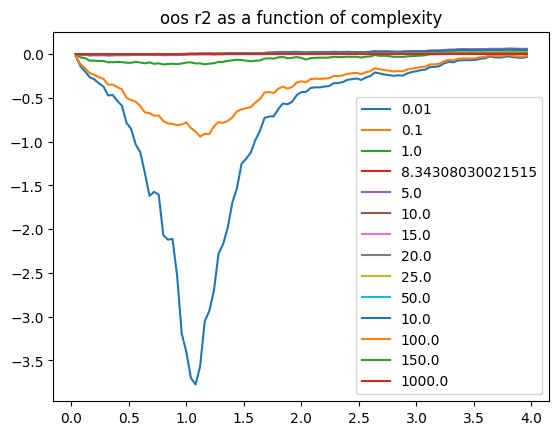

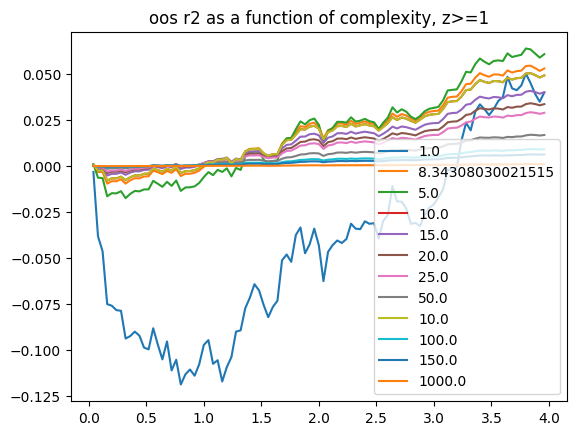

In [ ]:
# recall that split = size of the train sample (T in the lecture slides)
# c = P/T is used as the x-axis on the plots
voc_r2 = pd.DataFrame(voc_r2, index=voc_curve / split, columns=shrinkage_list)
voc_r2.plot(title='oos r2 as a function of complexity')
voc_r2.iloc[:, 2:].plot(title='oos r2 as a function of complexity, z>=1')

# In the real world, complexity comes not because we have lots of signals. Instead, we have **NONLINEARITIES.** It is non-linearities that bring complexity into the world. To deal with non-linearities, humans have invented feature engineering: They build lots of non-linear features and regress on those. While deep neural networks seem like more fancy algorithms, they are in the end close relatives of this simple approach


In [ ]:
d = 2
n = 500
split = int(n / 2)
np.random.seed(0)
raw_features = np.random.randn(n, d) # X_t, t = 1, ..., n (n= number of observations)
w = np.random.randn(d, 1)
scale = 2. # this scale defines whether a linear approximation is valid
true_linear_features = scale * raw_features @ w # X_t w
sigma = 0.1 # this defines the size of noise
noise = np.random.randn(n, 1) * sigma
# we subtract 0.5 so that labels are zero on average
# this is the true conditional expectation
# now we define f_*(x)
infeasible_nonlinear_predictions =  np.cos(true_linear_features) / (1 + np.exp(true_linear_features))
labels = infeasible_nonlinear_predictions + noise
test_labels = labels[split:]
train_labels = labels[:split]
infeasible_r2 = (infeasible_nonlinear_predictions ** 2).mean() / (labels ** 2).mean()
print(f'infeasible nonlinear predictions give an R2 of {infeasible_r2}')

infeasible nonlinear predictions give an R2 of 0.9623766087606259


# We have $y=f_*(x)+\epsilon$ so that the **infeasible non-linear predictions** (the conditional expectations) are given by $f_*(x)=E[y|x].$
#We know that $f_*(x) = \exp(w'x)/(1+\exp(w'x))-0.5$: a highly non-linear function that has **RANK ONE**: It only depends on one (unknown and hard to find) linear combination of raw features. Intuitively, when $w'x$ is close to zero, Taylor approximation $e^x\approx 1+x$ implies $y\approx 1+w'x$ and so the relation is a bit linear, so just regressing
$$
y\ \sim\ \beta'x +\ \tilde\epsilon
$$
#might give something, perhaps, the algorithm finds $\beta\sim w.$

In [ ]:
# FIRST WE TRY REGRESSING OUR NON-LINEAR FUNCTION ON LINEAR FEATURES
shrinkage_list = [0.01, 0.1, 1, 5, 10, 15, 20, 25, 50, 10, 100, 150, 1000]

signals = raw_features
beta_estimate_using_train_sample, predictions \
= ridge_regr(
            signals=signals[:split, :],
            labels=train_labels,
            future_signals=signals[split:],
            shrinkage_list=shrinkage_list)
performance_metrics_of_regression(test_labels,
                                  predictions)

r2 = [0.11 0.11 0.08 0.03 0.02 0.01 0.01 0.01 0.   0.02 0.   0.   0.  ]


(array([0.17447321, 0.17467254, 0.17990857, 0.18910973, 0.19178537,
        0.19284293, 0.19340859, 0.19376067, 0.19449509, 0.19178537,
        0.19487819, 0.19500835, 0.19523251]),
 array([0.10651395, 0.10549316, 0.07867919, 0.03155958, 0.01785749,
        0.0124417 , 0.00954492, 0.00774188, 0.00398091, 0.01785749,
        0.002019  , 0.00135245, 0.00020453]))

#Now we try the **random features approach**: We generate a bunch of non-linear transformations of the original data, $f_k(x),\ k=1,\cdots,P,$ for a large $P$, and try to see if we are able to get some of the non-linearities.

# The power (the ability to approximate the truth) of this model depends crucially on how **aligned** the features $f_k(x)$ are with the labels $y=f_*(x)+noise.$ For example, if, by chance $f_1(x)=f_*(x),$ then the model with $P=1$ will immeditely discover the truth.

# Inspired by neural networks, we seek $f_k(x)$ in a particular functional form: $f_k(x) = \sigma(\theta'x)$ where $\sigma$ is the activation function and $\theta$ are random weights. My favorite (and ML favorite as well) is $\sigma(x)=\max(x,0)=x\cdot {\bf 1}_{x>0}=ReLu(x).$ But we can also use $\sigma(x)=e^x.$
# The first question to ask is: can we even approximate a generic function like this? Do these features $f_k(x)$ have the **universal approximation property?** The answer is yes: as long as $\sigma(x)$ is a meaningful function, any continuous function $f_*(x)$ can be approximated as
$$
f_*(x)\ \approx\ \sum_{i=1}^P \beta_i\,\sigma(\theta_i' x)
$$
# as long as $P$ is sufficiently large. However, in reality, the universal approximation property is an abstraction. The main question we would like to answer is: Given a finite amount of data, how well can we approximate the truth? In general, the answer is that approximating truth is extremely difficult when the dimention of $x\in \mathbb R^d$ is high. This is known as the *curse of dimensionality.* Namely, why may need the number of observations  that is exponential in the dimension. Say, around $e^d.$ Already with $d=20$ this number becomes so large that the practical value of the universal approximation principle becomes zero.


<Axes: title={'center': 'oos r2 as a function of complexity truncated'}>

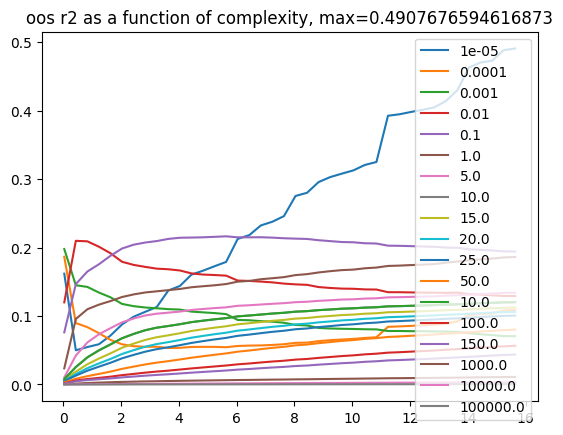

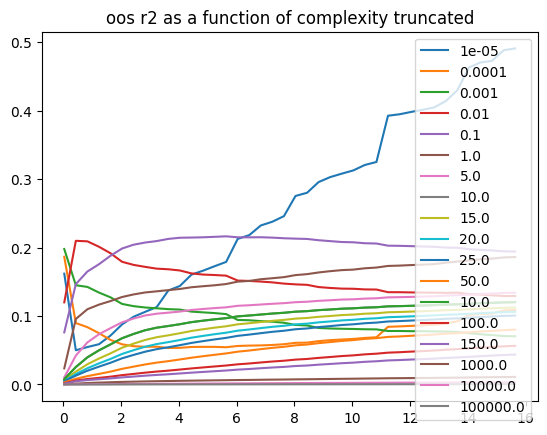

In [ ]:
p = 4000 # number of random features
np.random.seed(0)
# theta = np.random.laplace(0, 1, [d, p])
theta = np.random.randn(d, p) # random weights
random_linear_features = raw_features @ theta # \theta' x
band_width = 10 # an absolutely crucial parameter, defining the DEGREE OF NON-LINEARITY
# activation function is crucial as well. Please try cos, sin, exp
# exp with band_width = 20 and gaussian weights gives ok results, with r2 of 5%, slightly bigger than the 4% of the linear model
# signals = (random_linear_features / band_width) * ((random_linear_features / band_width) > 0)
signals = np.exp(random_linear_features / band_width) # \sigma(x) = cos(x/band_width)
shrinkage_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25, 50, 10, 100, 150, 1000, 10000, 100000]

voc_curve = np.arange(10, p, 100).astype(int)

predictions \
= [ridge_regr(
            signals=signals[:split, :p_],
            labels=train_labels,
            future_signals=signals[split:, :p_],
            shrinkage_list=shrinkage_list)[1] for p_ in voc_curve]

voc_r2 = np.concatenate([performance_metrics_of_regression(test_labels,
                                  predictions[i], printt=False)[1].reshape(1, -1) for i in range(len(voc_curve))], axis=0)
voc_r2 = pd.DataFrame(voc_r2, index=voc_curve / split, columns=shrinkage_list)
voc_r2.plot(title=f'oos r2 as a function of complexity, max={voc_r2.max().max()}')
(voc_r2 * (voc_r2 > -0.1)).plot(title='oos r2 as a function of complexity truncated')


In [ ]:
voc_r2.max(0)


0.00001         0.490768
0.00010         0.186529
0.00100         0.197837
0.01000         0.209837
0.10000         0.216402
1.00000         0.186181
5.00000         0.134053
10.00000        0.120203
15.00000        0.112333
20.00000        0.106096
25.00000        0.100661
50.00000        0.080052
10.00000        0.120203
100.00000       0.056470
150.00000       0.043683
1000.00000      0.011010
10000.00000     0.003206
100000.00000    0.000490
dtype: float64

$$
E[R_{t+1}\hat\pi_t(z)]\ =\ b_* (P^{-1}tr(\Psi)-z c^{-1} \xi(z))
$$
where
$$
\xi(z)\ =\ T^{-1}tr(\Psi (zI+\hat\Psi)^{-1})\ =\ \frac{1-zm(z)}{c^{-1}-1+zm(z)}
$$
#Our objecitve is to test whether
$$
\frac{E[R_{t+1}\hat\pi_t(z)]}{(P^{-1}tr(\Psi)-z c^{-1}\xi(z))}
$$
#is constant, independent of $z.$ If this is true, then indeed $\beta$ are i.i.d.

In [ ]:
expected_oos_return = (predictions[-1] * test_labels.reshape(-1, 1)).mean(0)
print(expected_oos_return)

[0.17035082 0.17035068 0.17034933 0.17033579 0.17020002 0.16880834
 0.16244717 0.15502588 0.14843658 0.14258361 0.13734074 0.11728288
 0.15502588 0.0928329  0.07774115 0.0236155  0.00440212 0.00062521]


#Expected out-of-sample (OOS) returns are positive and decreasing in $z$:

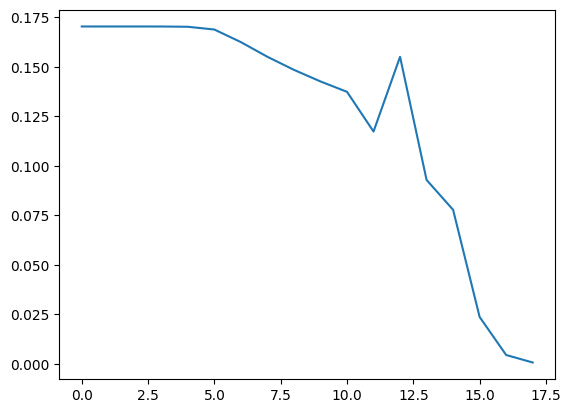

In [ ]:
plt.plot(expected_oos_return)

In [ ]:
psi_hat = signals[:split].T @ signals[:split] / split

In [ ]:
psi_hat.shape

(4000, 4000)

In [ ]:
psi_star = np.trace(psi_hat) / psi_hat.shape[1]


# Now we use the trick that $S'S/T$ and $SS'/T$ have the same non-zero eigenvalues, whereby $S'S/T$ will have $P-T$ zero eigenvalues, and we need to append them.

In [ ]:
if psi_hat.shape[1] < split:
  smart_eigenvalues, _ = np.linalg.eigh(psi_hat)
else:
  smart_eigenvalues, _ = np.linalg.eigh(signals[:split] @ signals[:split].T / split)
  smart_eigenvalues = list(smart_eigenvalues)
  # now I append P-T zeros
  smart_eigenvalues = [0] * (psi_hat.shape[1] - split) + smart_eigenvalues
smart_eigenvalues = np.array(smart_eigenvalues)


In [ ]:
stieltjes_transform_m = np.array([(1 / (smart_eigenvalues + z)).mean() for z in shrinkage_list])

#Stieltjes Transform $m(z)$ is monotone decreasing in $z$

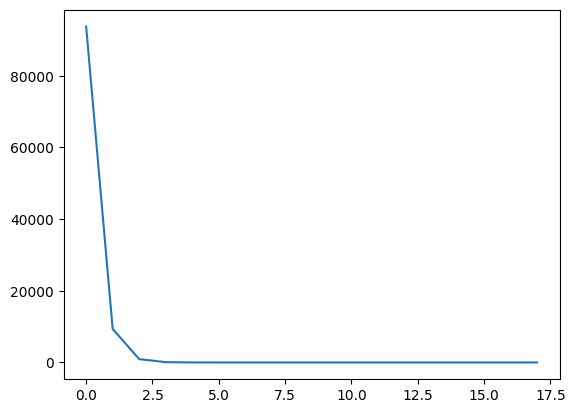

In [ ]:
plt.plot(stieltjes_transform_m)

In [ ]:
c = psi_hat.shape[1] / split # P/T
tmp = np.array(shrinkage_list) * stieltjes_transform_m
xi = (1 - tmp) / ((1 / c) - 1 + tmp)

#Recall that $$
\xi(z)\ =\ T^{-1}tr(\Psi (zI+\hat\Psi)^{-1})\ =\ \frac{1-zm(z)}{c^{-1}-1+zm(z)}
$$
#is positive and monotone decreasing in $z.$

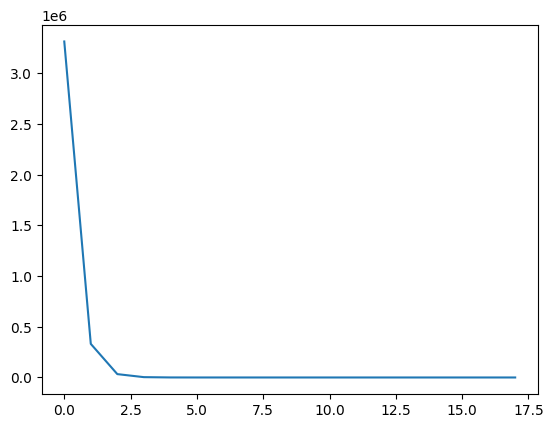

In [ ]:
plt.plot(xi)

In [ ]:
denominator = psi_star - np.array(shrinkage_list) * xi / c

# denominator should also be decreasing in $z$

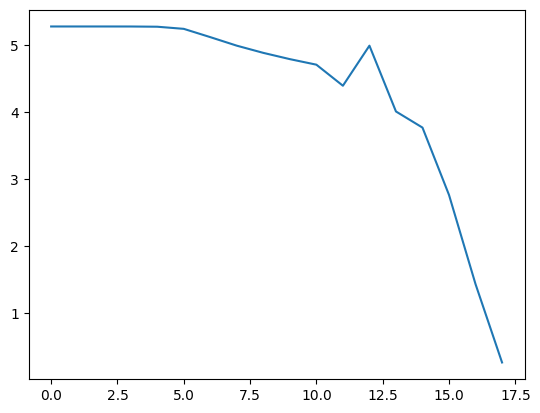

In [ ]:
plt.plot(denominator)

In [ ]:
b_star_estimate = expected_oos_return / denominator

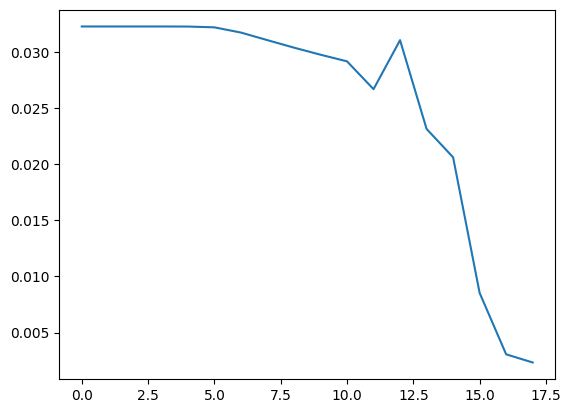

In [ ]:
plt.plot(b_star_estimate)

In [ ]:
theoretical_predictable_variation = b_star_estimate * psi_star
true_predictable_variation = (infeasible_nonlinear_predictions ** 2).mean()
print(true_predictable_variation)

0.2288545252789387


# We conclude that our original intuition is wrong: While it feels like the $\beta$ should be i.i.d. across our random features, the test clearly rejrects this. We now consider an idealized simulation experiment where $f_*(X)=\sum_i \beta_i f_i(x)$ where $\beta_i$ are sampled i.i.d.

In [ ]:
d = 100
n = 500
split = int(n / 2)
np.random.seed(0)
raw_features = np.random.randn(n, d)
w = np.random.randn(d, 1)
scale = 2. # this scale defines whether a linear approximation is valid
true_linear_features = scale * raw_features @ w
sigma = 1. # this defines the size of noise
noise = np.random.randn(n, 1) * sigma
# we subtract 0.5 so that labels are zero on average
# this is the true conditional expectation
# sample beta
b_star = 0.5
beta = np.sqrt(b_star) * np.random.randn(p, 1)
# normalization by sqrt(p) is important because otherwise it explodes
infeasible_nonlinear_predictions =  signals @ beta / np.sqrt(p)
labels = infeasible_nonlinear_predictions + noise
test_labels = labels[split:]
train_labels = labels[:split]
infeasible_r2 = (infeasible_nonlinear_predictions ** 2).mean() / (labels ** 2).mean()
print(f'infeasible nonlinear predictions give an R2 of {infeasible_r2}')

infeasible nonlinear predictions give an R2 of 0.7436926305829941


# We can check directly that $E[(\beta'S_t)^2]=\beta'E[S_tS_t']\beta\approx b_* P^{-1}tr(\Psi)\ =\ b_*\psi_{*,1}.$

In [ ]:
psi_star = np.trace(psi_hat) / p

realized_predictable_variation = (infeasible_nonlinear_predictions ** 2).mean()
theoretical = b_star * psi_star
print(theoretical, realized_predictable_variation)

73.49815356351885 70.22124326579424


In [ ]:
predictions = ridge_regr(signals=signals[:split, :],
                        labels=train_labels,
                        future_signals=signals[split:, :],
                        shrinkage_list=shrinkage_list)



[2.49800779 2.49800478 2.49797474 2.49767449 2.49468412 2.46593038
 2.35776056 2.25207274 2.16647472 2.09421012 2.0315325  1.80245701
 2.25207274 1.5345756  1.37154683 0.76404031 0.34088082 0.06216504]


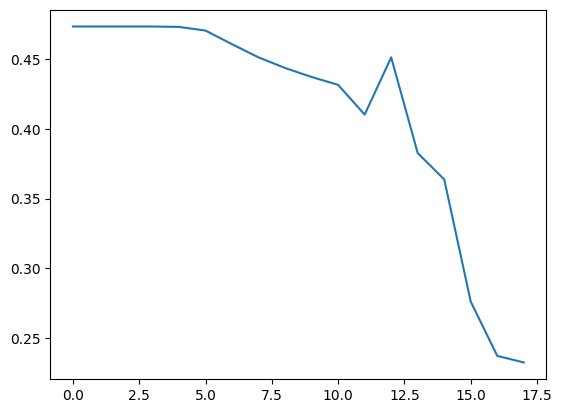

In [ ]:
expected_oos_return = (predictions[-1] * test_labels.reshape(-1, 1)).mean(0)
print(expected_oos_return)
b_star_estimate = expected_oos_return / denominator
plt.plot(b_star_estimate)

In [ ]:
performance_metrics_of_regression(test_labels,
                                  predictions[-1], printt=False)

(array([3.02132814, 3.02132563, 3.02130054, 3.02104995, 3.01857579,
        2.9966834 , 2.93934532, 2.91109007, 2.90267516, 2.90369225,
        2.90985786, 2.96929525, 2.91109007, 3.10752343, 3.22791552,
        3.91019864, 4.43330658, 4.86719405]),
 array([0.39416161, 0.39416211, 0.39416714, 0.39421739, 0.39471351,
        0.39910339, 0.41060085, 0.41626661, 0.41795397, 0.41775002,
        0.41651369, 0.40459527, 0.41626661, 0.37687768, 0.35273659,
        0.2159248 , 0.11103091, 0.02402755]))

# We now investigate the case when $\beta$ is sparse




#When betas are sparse, theoretically, a better way of shrinking is by imposing sparsity through [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics))
#that penalizes regression through $(1 / (2 * T)) * \|R - S\beta\|^2_2 + \alpha \|\beta\|_1$ where $\|\beta\|_1=\sum_i|\beta_i|.$ This is in stark contrast to ridge regression that uses $\|\beta\|_2=\sum_i \beta_i^2.$ Choosing larger $\alpha$ penalizes more and leads to more sparsity. When $\alpha$ is too large, it actually shrinks all coefficients to zero. LASSO can be potentially extremely powerful when the data exhibits extreme sparsity. For example, [Sparse Signals in the Cross-Section of Stock Returns](https://alexchinco.com/sparse-signals-in-cross-section.pdf) show that this is the case when only few stock returns respond to high frequency news.

#But what does "extreme sparsity" mean mathematically? Remarkable results of [The Dantzig selector: Statistical estimation when $p$ is much larger than $n$](https://projecteuclid.org/journals/annals-of-statistics/volume-35/issue-6/The-Dantzig-selector--Statistical-estimation-when-p-is-much/10.1214/009053606000001523.full) imply that LASSO works when the true number $p_0$ of non-zero $\beta$ coefficients is small and $\log(p)$ is small, with the error scaling like $p_0 \log(p)$. Thus, the bigger $p_0$, the harder is to use sparsity (although there are ways to deal with this. See [Sure Screening](https://rss.onlinelibrary.wiley.com/doi/pdfdirect/10.1111/j.1467-9868.2008.00674.x))

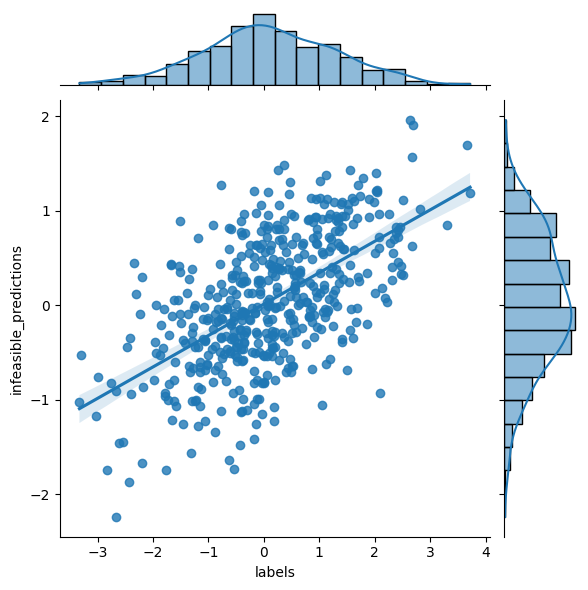

In [ ]:
sample_size = 500 # this is n = number of observations
number_features = 1000 # this is p = number of features
noise_size = 1.
seed = 1
p_0 = 1 # number of non-zero betas . Please also do an experiment for p_0 = 100
(labels, infeasible_predictions, signals, betas) = simulate_data(seed,
                                                                 sample_size,
                                                                 number_features,
                                                                 noise_size,
                                                                 bstar=0.5,
                                                                 binomial=True,
                                                                 fraction_nonzero_betas=p_0 / number_features
                                                                 )


scatter_plot(labels,
             infeasible_predictions,
             'labels',
             'infeasible_predictions')

In [ ]:
split = int(sample_size / 2)
train_labels = labels[:split]
test_labels = labels[split:]

In [ ]:
b_star = (betas ** 2).sum()
print(f'b_star={b_star}')
c_ = number_features / sample_size
z_optimal = c_ / b_star
print(f'z_optimal={z_optimal}')
shrinkage_list = [0.01, 0.1, 1, z_optimal, 5, 10, 15, 20, 25, 50, 10, 100, 150, 1000, 2000, 3000, 5000, 10000]

b_star=0.5000000000000001
z_optimal=3.999999999999999


In [ ]:
beta_estimate_using_train_sample, predictions \
= ridge_regr(
            signals=signals[:split, :],
            labels=train_labels,
            future_signals=signals[split:],
            shrinkage_list=shrinkage_list)



r2 = [-0.07 -0.05  0.02  0.06  0.06  0.05  0.04  0.04  0.03  0.02  0.05  0.01
  0.01  0.    0.    0.    0.    0.  ]


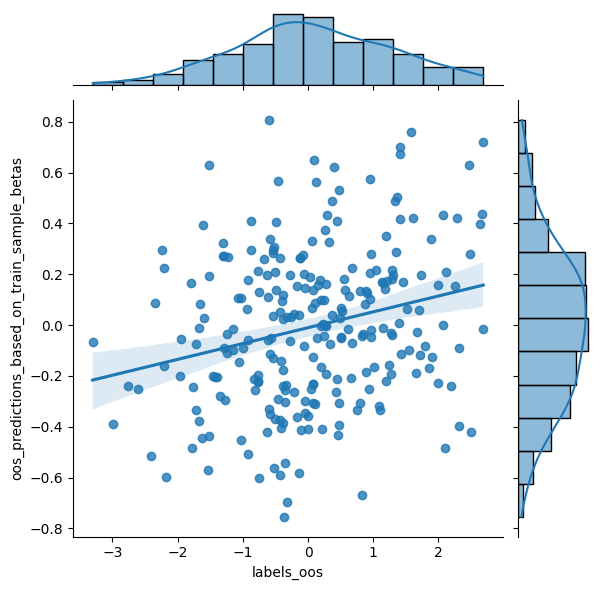

In [ ]:
col = 3 # this is the index of the optimal z (ridge penalty) inside the list of ridge penalties

performance_metrics_of_regression(test_labels,
                                  predictions)

scatter_plot(labels[split:],
             predictions[:, col].reshape(-1, 1),
             'labels_oos',
             'oos_predictions_based_on_train_sample_betas')

In [ ]:
from sklearn import linear_model
lasso_coefs = list()
lasso_oos_predictions = list()
for alpha in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]:
  clf = linear_model.Lasso(alpha=alpha)
  clf.fit(signals[:split, :], train_labels)
  lasso_coefs += [clf.coef_.reshape(-1, 1)]
  lasso_oos_predictions += [clf.predict(signals[split:, :]).reshape(-1, 1)]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.296e-02, tolerance: 3.761e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.733e-02, tolerance: 3.761e-02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
lasso_coefs = np.concatenate(lasso_coefs, axis=1)
lasso_oos_predictions = np.concatenate(lasso_oos_predictions, axis=1)



In [ ]:
betas

In [ ]:
tmp = np.concatenate([lasso_coefs, betas.reshape(-1, 1)], axis=1)
print(f'LASSO thinks that there are {(np.abs(tmp[:, :-1]) > 0).sum(0)} non-zero betas')
index=betas>0
alignment = (pd.DataFrame(tmp[index.flatten(), :-1]).abs() > 0).sum()
print(f'let us see how many correct betas it guessed: \n {alignment}')

LASSO thinks that there are [1000  797  403  259  219   51    2    1] non-zero betas
let us see how many correct betas it guessed: 
 0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
dtype: int64


In [ ]:
print(((np.abs(tmp[:, 0]) > 0) * (np.abs(tmp[:, 8]) > 0)).sum())

10


#As we will now see, ridge beats LASSO massively in the sparse setting and p_0 = 100 (while LASSO beats ridge when p_0=10). The optimal shrinkage is still the same, but the Rsquared is much lower. This is very surprising and cintradicts the conventional wisdom. Would be nice to investigate the situation with real data where sparsity is natural. See, e.g., [Sparse Signals](https://alexchinco.com/sparse-signals-in-cross-section.pdf)

In [ ]:
lasso_coefs.shape
print((np.abs(lasso_coefs) > 0).sum(0))

[1000  809  419  266  230   66    9    0]


r2 = [-0.67 -0.37  0.05 -0.01  0.09  0.27  0.28  0.19]


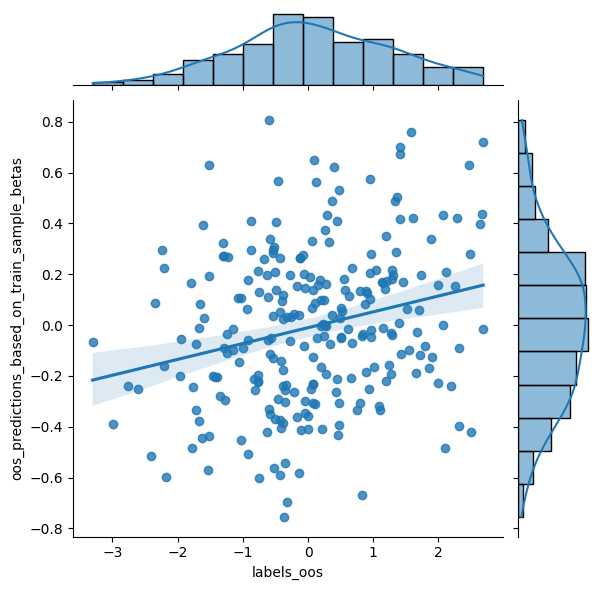

In [ ]:
col = 3 # this is the optimal z

performance_metrics_of_regression(test_labels,
                                  lasso_oos_predictions)

scatter_plot(labels[split:],
             predictions[:, col].reshape(-1, 1),
             'labels_oos',
             'oos_predictions_based_on_train_sample_betas')